In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/PTA加工费.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['PTA加工费'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,PTA加工费,PTA中国大陆负荷/4WMA,聚酯（涤丝）加权平均库存天数超季节性/5年,乙二醇煤制利润,Brent原油期货价格,POY华东市场价/1150D/48F,织造订单天数,周度聚酯负荷
2025-11-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
sheet.columns

Index(['PTA加工费', 'PTA中国大陆负荷/4WMA', '聚酯（涤丝）加权平均库存天数超季节性/5年', '乙二醇煤制利润',
       'Brent原油期货价格', 'POY华东市场价/1150D/48F', '织造订单天数', '周度聚酯负荷'],
      dtype='object')

In [6]:
################################# 处理缺失值 #################################
fill_methods = {
'PTA中国大陆负荷/4WMA': 'interpolate', 
'聚酯（涤丝）加权平均库存天数超季节性/5年': 'interpolate', 
'乙二醇煤制利润': 'interpolate',
'Brent原油期货价格': 'interpolate', 
'POY华东市场价/1150D/48F': 'interpolate', 
'织造订单天数': 'interpolate', 
'周度聚酯负荷': 'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
#sheet.loc[:last_day, 'LME铜价'] = sheet.loc[:last_day, 'LME铜价'].interpolate(method='linear')

#################################  因子处理  #################################

sheet['PTA中国大陆负荷/4WMA_提前20天'] = sheet['PTA中国大陆负荷/4WMA'].shift(20)
sheet['聚酯（涤丝）加权平均库存天数超季节性/5年_提前40天'] = sheet['聚酯（涤丝）加权平均库存天数超季节性/5年'].shift(40)
sheet['乙二醇煤制利润_提前40天'] = sheet['乙二醇煤制利润'].shift(40)
sheet['Brent原油期货价格_提前80天'] = sheet['Brent原油期货价格'].shift(80)
sheet['POY华东市场价/1150D/48F_提前60天'] = sheet['POY华东市场价/1150D/48F'].shift(60)
sheet['织造订单天数_提前30天'] = sheet['织造订单天数'].shift(30)
sheet['周度聚酯负荷_提前20天'] = sheet['周度聚酯负荷'].shift(20)

sheet['PTA中国大陆负荷/4WMA_提前20天_逆序'] = reverse_column(sheet, 'PTA中国大陆负荷/4WMA_提前20天')
sheet['聚酯（涤丝）加权平均库存天数超季节性/5年_提前40天_逆序'] = reverse_column(sheet, '聚酯（涤丝）加权平均库存天数超季节性/5年_提前40天')
sheet['乙二醇煤制利润_提前40天_逆序'] = reverse_column(sheet, '乙二醇煤制利润_提前40天')


################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-01-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['PTA加工费'].notna())
]

################################# 数据 读取-处理 结束 #################################

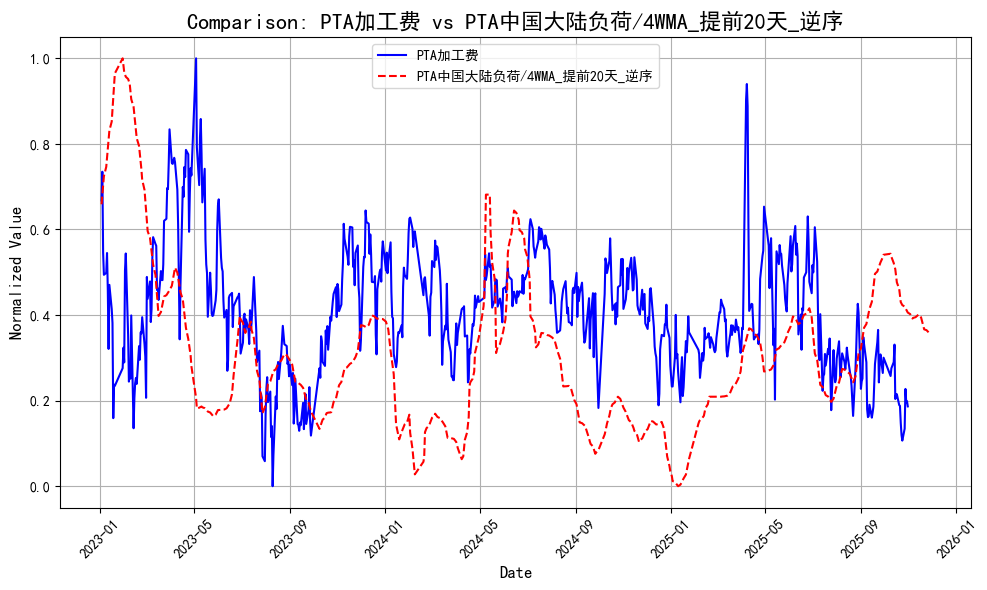

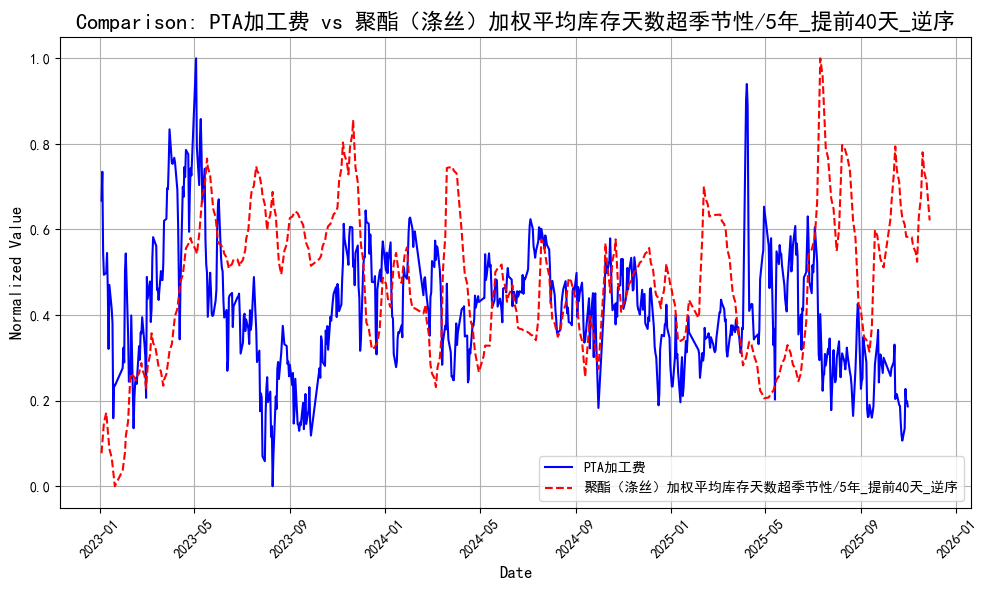

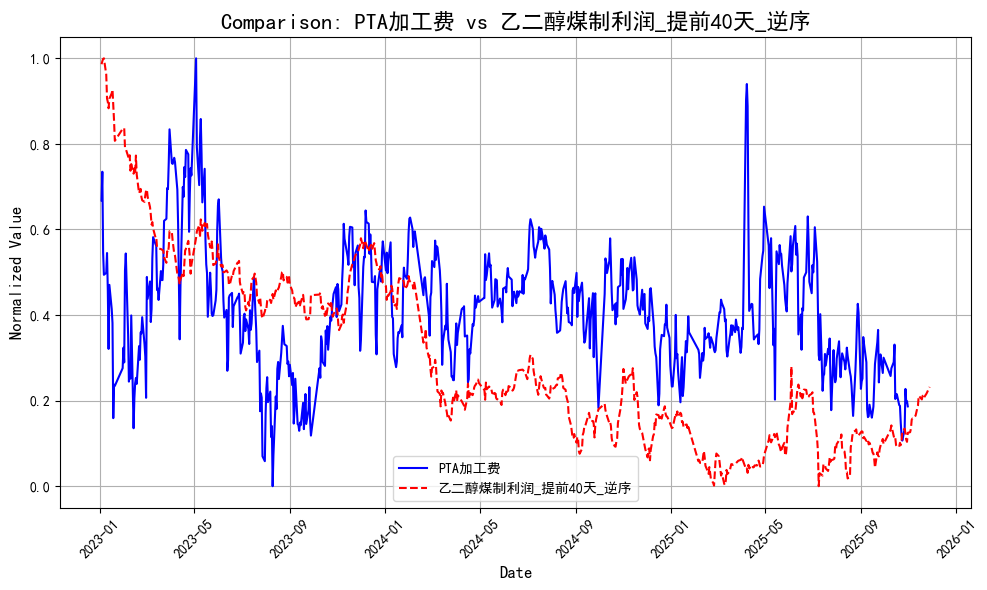

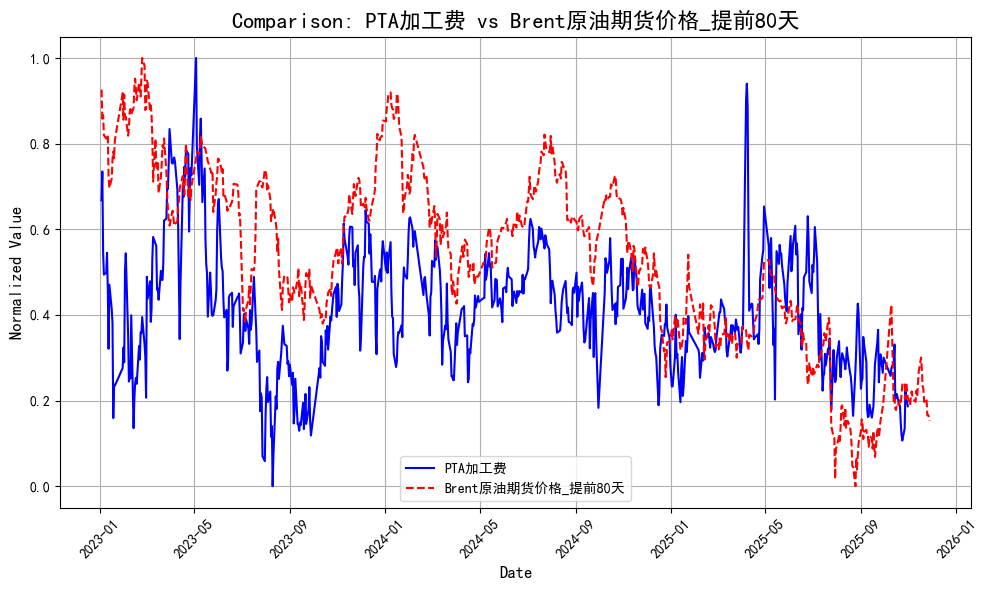

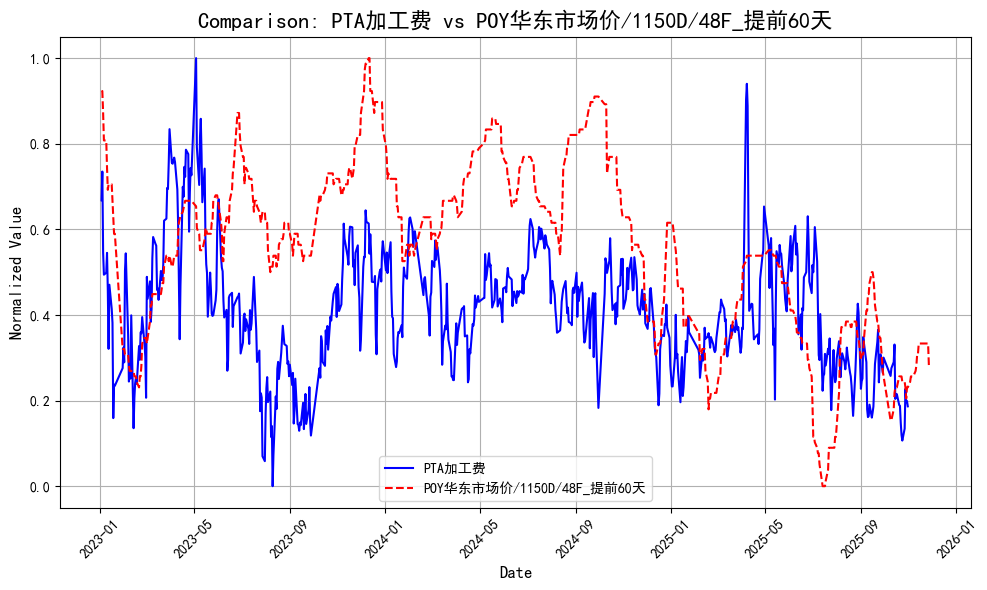

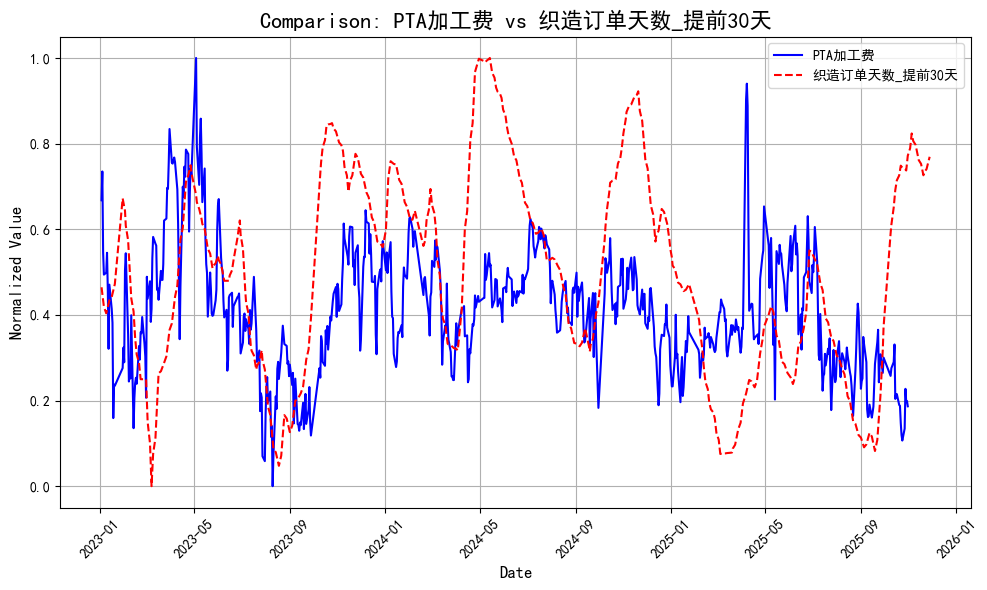

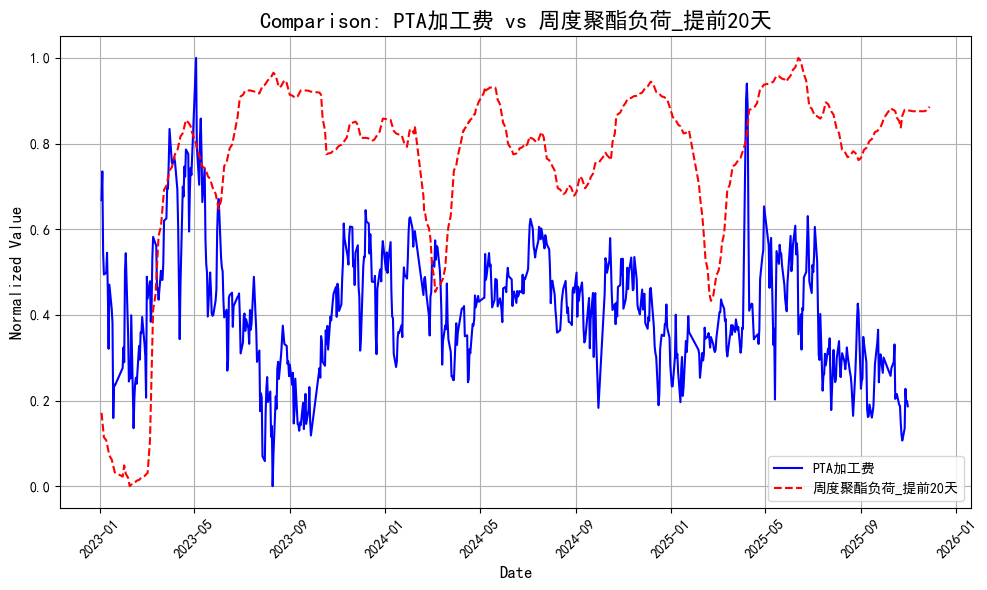

In [7]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='PTA加工费', 
    compare_cols=[
        'PTA中国大陆负荷/4WMA_提前20天_逆序',
        '聚酯（涤丝）加权平均库存天数超季节性/5年_提前40天_逆序',
        '乙二醇煤制利润_提前40天_逆序',
        'Brent原油期货价格_提前80天',
        'POY华东市场价/1150D/48F_提前60天',
        '织造订单天数_提前30天',
        '周度聚酯负荷_提前20天'
        ]
)

In [8]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 30
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        'PTA中国大陆负荷/4WMA_提前20天_逆序',
        '聚酯（涤丝）加权平均库存天数超季节性/5年_提前40天_逆序',
        '乙二醇煤制利润_提前40天_逆序',
        'Brent原油期货价格_提前80天',
        'POY华东市场价/1150D/48F_提前60天',
        '织造订单天数_提前30天',
        '周度聚酯负荷_提前20天'
]

predict_column = 'PTA加工费'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.0886,  # 较小的学习率
    'max_depth': 9,  # 控制树的深度防止过拟合
    'min_child_weight': 2.386014504687225,  # 控制过拟合
    'subsample': 0.6775532059420997,  # 随机采样防止过拟合
    'colsample_bytree': 0.9987014184689909,  # 特征随机采样
    'gamma': 0.007382450003450058,  # 控制分裂
    'reg_alpha': 0.03545994150883014,  # L1正则化
    'reg_lambda': 0.7042006808046778,  # L2正则化
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
    'max_delta_step': 5,
    'tree_method': 'auto'
}


num_boost_round = 5000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=100 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:156.34952	train-rmse:101.26691


[100]	eval-rmse:175.62660	train-rmse:76.07547


[200]	eval-rmse:189.08947	train-rmse:56.38294


[300]	eval-rmse:194.31424	train-rmse:40.70569


[400]	eval-rmse:196.56293	train-rmse:28.40700


[500]	eval-rmse:197.70042	train-rmse:19.69604


[600]	eval-rmse:199.93050	train-rmse:13.64899


[700]	eval-rmse:200.22540	train-rmse:9.95280


[800]	eval-rmse:200.70802	train-rmse:7.79829


[900]	eval-rmse:200.63001	train-rmse:6.13035


[1000]	eval-rmse:200.66104	train-rmse:4.74768


[1100]	eval-rmse:200.40922	train-rmse:3.46089


[1200]	eval-rmse:200.10369	train-rmse:2.42924


[1300]	eval-rmse:200.00297	train-rmse:1.62522


[1400]	eval-rmse:199.88368	train-rmse:0.96364


[1500]	eval-rmse:199.65995	train-rmse:0.57403


[1600]	eval-rmse:199.57226	train-rmse:0.35887


[1700]	eval-rmse:199.57944	train-rmse:0.21648


[1800]	eval-rmse:199.57816	train-rmse:0.13701


[1900]	eval-rmse:199.55611	train-rmse:0.09544


[2000]	eval-rmse:199.55954	train-rmse:0.07460


[2100]	eval-rmse:199.55462	train-rmse:0.06477


[2200]	eval-rmse:199.55398	train-rmse:0.06077


[2300]	eval-rmse:199.55625	train-rmse:0.05852


[2400]	eval-rmse:199.55748	train-rmse:0.05712


[2500]	eval-rmse:199.55735	train-rmse:0.05592


[2600]	eval-rmse:199.55679	train-rmse:0.05448


[2700]	eval-rmse:199.55493	train-rmse:0.05376


[2800]	eval-rmse:199.55490	train-rmse:0.05296


[2900]	eval-rmse:199.55518	train-rmse:0.05254


[3000]	eval-rmse:199.55436	train-rmse:0.05192


[3100]	eval-rmse:199.55231	train-rmse:0.05169


[3200]	eval-rmse:199.55195	train-rmse:0.05151


[3300]	eval-rmse:199.55377	train-rmse:0.05092


[3400]	eval-rmse:199.55378	train-rmse:0.05075


[3500]	eval-rmse:199.55306	train-rmse:0.05036


[3600]	eval-rmse:199.55554	train-rmse:0.04997


[3700]	eval-rmse:199.55557	train-rmse:0.04961


[3800]	eval-rmse:199.55125	train-rmse:0.04933


[3900]	eval-rmse:199.55163	train-rmse:0.04920


[4000]	eval-rmse:199.55066	train-rmse:0.04894


[4100]	eval-rmse:199.55076	train-rmse:0.04883


[4200]	eval-rmse:199.54956	train-rmse:0.04878


[4300]	eval-rmse:199.55042	train-rmse:0.04851


[4400]	eval-rmse:199.55175	train-rmse:0.04824


[4500]	eval-rmse:199.55099	train-rmse:0.04808


[4600]	eval-rmse:199.55202	train-rmse:0.04796


[4700]	eval-rmse:199.55130	train-rmse:0.04779


[4800]	eval-rmse:199.55081	train-rmse:0.04769


[4900]	eval-rmse:199.55104	train-rmse:0.04755


[4999]	eval-rmse:199.55108	train-rmse:0.04738


训练集 MSE (DMatrix): 0.0032, 训练集 R² (DMatrix): 1.0
测试集 MSE (DMatrix): 39820.6334, 测试集 R² (DMatrix): -14.3212


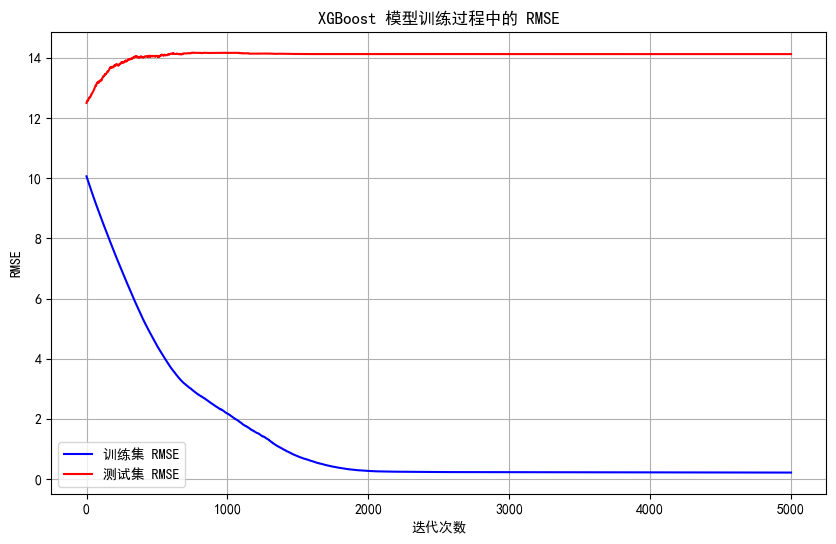

In [9]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=100
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:103.76879


[100]	train-rmse:79.27409


[200]	train-rmse:60.05489


[300]	train-rmse:44.06692


[400]	train-rmse:31.09186


[500]	train-rmse:21.79209


[600]	train-rmse:15.22855


[700]	train-rmse:11.07574


[800]	train-rmse:8.51592


[900]	train-rmse:6.73533


[1000]	train-rmse:5.29263


[1100]	train-rmse:3.88729


[1200]	train-rmse:2.70656


[1300]	train-rmse:1.72521


[1400]	train-rmse:0.93473


[1500]	train-rmse:0.52471


[1600]	train-rmse:0.33724


[1700]	train-rmse:0.21411


[1800]	train-rmse:0.15327


[1900]	train-rmse:0.10158


[2000]	train-rmse:0.08136


[2100]	train-rmse:0.06838


[2200]	train-rmse:0.06411


[2300]	train-rmse:0.06047


[2400]	train-rmse:0.05826


[2500]	train-rmse:0.05687


[2600]	train-rmse:0.05593


[2700]	train-rmse:0.05495


[2800]	train-rmse:0.05416


[2900]	train-rmse:0.05356


[3000]	train-rmse:0.05274


[3100]	train-rmse:0.05243


[3200]	train-rmse:0.05212


[3300]	train-rmse:0.05174


[3400]	train-rmse:0.05144


[3500]	train-rmse:0.05107


[3600]	train-rmse:0.05069


[3700]	train-rmse:0.05065


[3800]	train-rmse:0.05021


[3900]	train-rmse:0.05003


[4000]	train-rmse:0.04954


[4100]	train-rmse:0.04941


[4200]	train-rmse:0.04933


[4300]	train-rmse:0.04926


[4400]	train-rmse:0.04916


[4500]	train-rmse:0.04883


[4600]	train-rmse:0.04883


[4700]	train-rmse:0.04854


[4800]	train-rmse:0.04852


[4900]	train-rmse:0.04850


[4999]	train-rmse:0.04829


全部数据 MSE: 0.0035, 全部数据 R²: 1.0


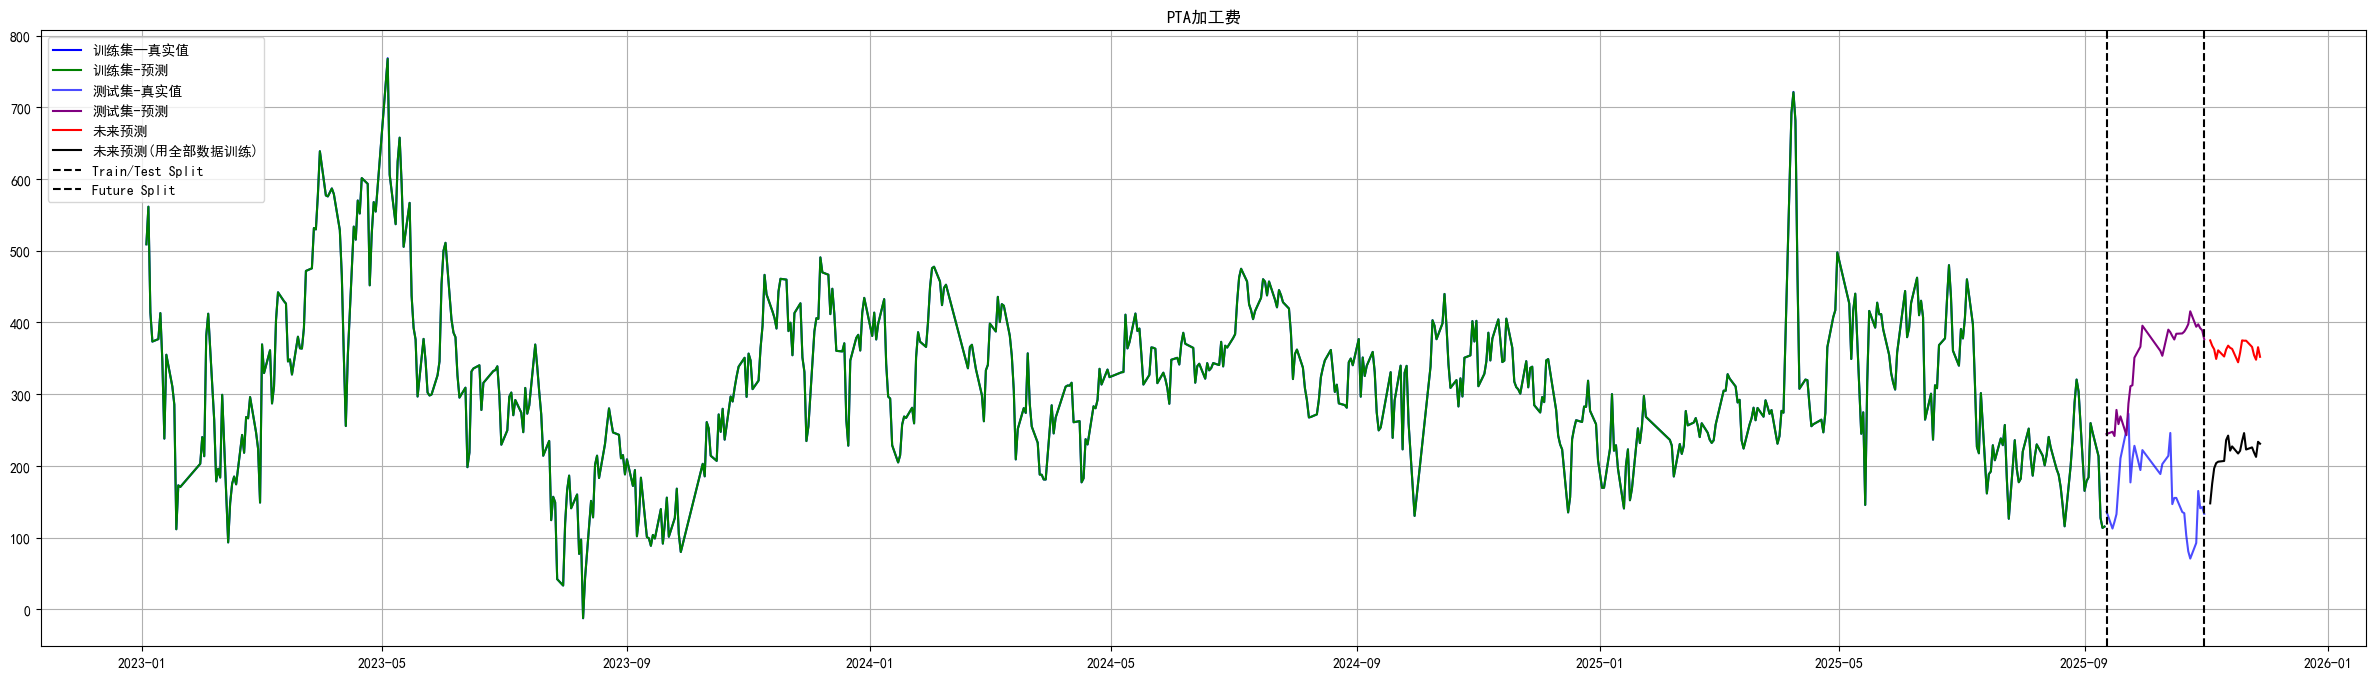

In [11]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('PTA加工费')
plt.legend()
plt.grid(True)
plt.show()

---

In [12]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/PTA加工费_合并数据.xlsx', index=False,float_format='%.1f')

merged_df_daily

,Date,真实值,预测值
702,2025/11/28,NaN,231.033691
701,2025/11/27,NaN,233.701508
700,2025/11/26,NaN,212.678406
699,2025/11/25,NaN,218.761459
698,2025/11/24,NaN,225.893494
...,...,...,...
4,2023/01/09,376.8443,NaN
3,2023/01/06,373.3537,NaN
2,2023/01/05,413.8545,NaN
1,2023/01/04,561.3697,NaN


In [13]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel
merged_df_monthly.to_excel('eta/PTA加工费_月度数据.xlsx', index=False, float_format='%.1f')
merged_df_monthly

,Date,真实值,预测值
34,2025/11/30,NaN,216.418777
33,2025/10/31,147.600176,385.780212
32,2025/09/30,183.942555,245.970840
31,2025/08/31,217.845414,217.846649
30,2025/07/31,256.514252,256.510651
29,2025/06/30,378.488655,378.490356
28,2025/05/31,354.199800,354.196503
27,2025/04/30,373.367895,373.362244
26,2025/03/31,279.971138,279.969818
25,2025/02/28,241.721267,241.720520


---

In [14]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.化工_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "PTA加工费"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [15]:
from Lcel import update_excel_data
file_path = "eta/1.化工_数据上传.xlsx"
sheet_name = "详情页"
identifier = "PTA加工费"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
